In [2]:
!git clone https://github.com/Prashant-AV/Qualcomm-DL-Hackathon/

Cloning into 'Qualcomm-DL-Hackathon'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 30.68 MiB | 31.51 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
!unzip -q "/content/Qualcomm-DL-Hackathon/train/images part-1.zip" -d "/content/Qualcomm-DL-Hackathon/train/"
!unzip -q "/content/Qualcomm-DL-Hackathon/train/images part-2.zip" -d "/content/Qualcomm-DL-Hackathon/train/"

In [4]:
import pandas as pd
import os


## name of folders are changed
if not os.path.exists("/content/Qualcomm-DL-Hackathon/train/images_part-1"):
  os.rename(r"/content/Qualcomm-DL-Hackathon/train/images part-1","/content/Qualcomm-DL-Hackathon/train/images_part-1")
if not os.path.exists("/content/Qualcomm-DL-Hackathon/train/images_part-2"):
  os.rename(r"/content/Qualcomm-DL-Hackathon/train/images part-2","/content/Qualcomm-DL-Hackathon/train/images_part-2")

train_csv = r"./Qualcomm-DL-Hackathon/train/train.csv" #"/content/Qualcomm-DL-Hackathon/train/train.csv"
train_df = pd.read_csv(train_csv)

test_csv = r"./Qualcomm-DL-Hackathon/test.csv"
test_df = pd.read_csv(test_csv)

im_pt_1 =  r"./Qualcomm-DL-Hackathon/train/images_part-1" #"/content/Qualcomm-DL-Hackathon/train/images_part-1"
base,_,images = next(os.walk(im_pt_1))

images_path = list(map(lambda im : os.path.join(base,im),images))


im_pt_2 = r"./Qualcomm-DL-Hackathon/train/images_part-2" #"/content/Qualcomm-DL-Hackathon/train/images_part-2"
base,_,images2 = next(os.walk(im_pt_2))

images2_path = list(map(lambda im : os.path.join(base,im),images2))

images.extend(images2)
images_path.extend(images2_path)

image_path_lookup = dict(zip(images,images_path))

paths = []
for r in train_df.iterrows():
  im = r[1].iloc[0]
  pth = image_path_lookup.get(im,None)
  #print(im,pth)
  if not pth:
    print(im)
  paths.append(pth)

train_df["paths"] = paths

paths = []
for r in test_df.iterrows():
  im = r[1].iloc[0]
  pth = image_path_lookup.get(im,None)
  #print(im,pth)
  if not pth:
    print(im)
  paths.append(pth)

test_df["paths"] = paths


test_df.head()



,image_names,paths
0,1960.jpg,./Qualcomm-DL-Hackathon/train/images_part-2/19...
1,668.jpg,./Qualcomm-DL-Hackathon/train/images_part-1/66...
2,2082.jpg,./Qualcomm-DL-Hackathon/train/images_part-2/20...
3,808.jpg,./Qualcomm-DL-Hackathon/train/images_part-1/80...
4,1907.jpg,./Qualcomm-DL-Hackathon/train/images_part-2/19...


In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image = Image.open(r"./Qualcomm-DL-Hackathon/train/images_part-2/1503.jpg")
image.size

(224, 224)

In [5]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):

        self.image_paths = dataframe["paths"].to_list()
        self.labels = dataframe["emergency_or_not"].to_list()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        image_name = img_path.split("/")[-1]

        if self.transform:
            image = self.transform(image)

        return image_name,image,float(label)


class CustomTestImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):

        self.image_paths = dataframe["paths"].to_list()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx >= len(self.image_paths):
            print(idx)
            raise IndexError
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        image_name = img_path.split("/")[-1]

        if self.transform:
            image = self.transform(image)

        return image_name,image


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform = transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CustomImageDataset(train_df, transform=transform)
#test_dataset = CustomImageDataset(test_df, transform=transform)
batch_size = 32
validation_split = 0.25
shuffle_dataset = True
random_seed= 42

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                           sampler=train_sampler)
validation_loader = DataLoader(train_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


test_dataset = CustomTestImageDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset)


In [ ]:
len(val_indices)

329

torch.Size([15, 3, 224, 224])
1171.jpg
tensor(0., dtype=torch.float64)


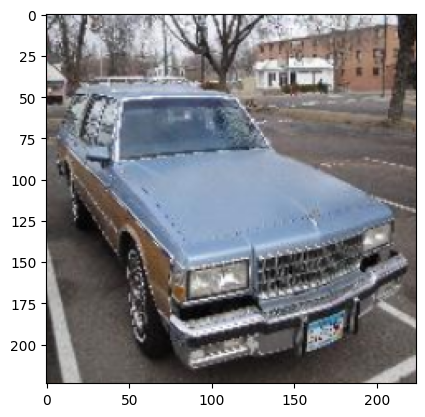

In [ ]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

name,images, labels = next(iter(train_loader))
print(images.size())
print(name[0])
print(labels[0])
imshow(images[0])

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch

hidden_layer1 = 32
hidden_layer2 = 64
hidden_layer3 = 128
hidden_layer4 = 64
hidden_layer5 = 32


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, hidden_layer1, 3)
        self.conv2 = nn.Conv2d(hidden_layer1, hidden_layer2, 3)
        self.conv3 = nn.Conv2d(hidden_layer2, hidden_layer3, 3)
        #self.conv4 = nn.Conv2d(hidden_layer3, hidden_layer4, 3)
        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(hidden_layer3 * 54 * 54, hidden_layer4)
        #self.fc2 = nn.Linear(hidden_layer4, hidden_layer5)
        self.fc3 = nn.Linear(hidden_layer4, 1)
        self.float()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = self.dropout(self.pool(F.relu(self.conv3(x))))
        #x = self.dropout(self.pool(F.relu(self.conv4(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(self.fc1(x))
        #x = self.dropout(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x.squeeze(1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=373248, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [12]:
def check_accuracy(validation_loader,loss_fn):
    total,correct = 0,0
    run_loss = 0
    n = 0
    with torch.no_grad():
        #data = validation_loader:
        for data in validation_loader:
          _,images, labels = data
          labels = labels.type(torch.DoubleTensor)
          outputs = net(images).type(torch.DoubleTensor)
          run_loss += loss_fn(outputs,labels).item()
          #print(labels,outputs)
          labels = labels.type(torch.IntTensor)
          predicted = torch.round(outputs).type(torch.IntTensor)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          n += 1
    loss = run_loss/n
    return loss,correct / total

#check_accuracy(validation_loader,criterion)

(0.669546142605607, 67.39659367396594)

In [10]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0001,weight_decay=1e-2)

last_acc = 0
for epoch in range(8):  # loop over the dataset multiple times
    running_loss = 0.0
    last_loss = 0.0
    net.train(True)
    for i,data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        _,inputs, labels = data
        labels = labels.type(torch.DoubleTensor)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).type(torch.DoubleTensor)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10
            print(f'training loss : {last_loss} after {i + 1} iterations')
            running_loss = 0

    print(f'training loss : {last_loss} after {epoch + 1}')
    net.eval()
    vloss,acc = check_accuracy(validation_loader,criterion)
    print(f'accuracy : {acc}, validation loss : {vloss} after {epoch + 1}')
    if acc > last_acc:
        last_acc = acc
        torch.save(net.state_dict(), "model.pt")

print('Finished Training')

training loss : 1.3883432631691668 after 10 iterations
training loss : 0.8104892044014351 after 20 iterations
training loss : 0.7287169013493815 after 30 iterations
training loss : 0.7287169013493815 after 1


RuntimeError: Found dtype Int but expected Float

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

with torch.no_grad():
    for data in validation_loader:
        imnane,images, labels = data
        labels = labels.type(torch.IntTensor)
        # calculate outputs by running images through the network
        outputs = net(images)
        #print(labels,outputs)
        predicted = torch.round(outputs).type(torch.IntTensor)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(labels,predicted)


print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

accuracy = 100 * correct / total

Accuracy of the network on the 411 test images: 79.56204379562044 %


In [ ]:
net = Net()
net.load_state_dict(torch.load("/content/model.pt", weights_only=True))
net.eval()


records = {"image_names" : [],"emergency_or_not" : []}
with torch.no_grad():
    for data in test_loader:
        imname,images = data
        # calculate outputs by running images through the network
        outputs = net(images)
        #print(labels,outputs)
        predicted = torch.round(outputs).type(torch.IntTensor)
        #print(labels,predicted)
        records["image_names"].extend(imname)
        records["emergency_or_not"].extend(predicted.tolist())

sub_df = pd.DataFrame.from_dict(records)
sub_df.to_csv("my_submission.csv",index=False)

,0
image_names,0
paths,0


In [ ]:
(43264 * 64) / 15

184593.06666666668

In [ ]:
184593 ** 0.5

429.64287495546813